In [1]:
using JuMP, NamedArrays, PyPlot, PyCall, Distributions;

## Data Generation

In [2]:
function get_r(a,b,θ,ϕ)
    return sqrt(1/((cos(ϕ-θ)/a)^2+(sin(θ-ϕ)/b)^2))
end

function generate_ellipse(a, b, θ=0, n=100, noise=0.1)
    ϕ = sort(rand(n)*2*π)
    r = [ get_r(a,b,θ,i)+rand(Normal(0, noise)) for i in ϕ ]
    ellipsematrix = hcat(ϕ,r)
    return ellipsematrix
end

generate_ellipse (generic function with 4 methods)

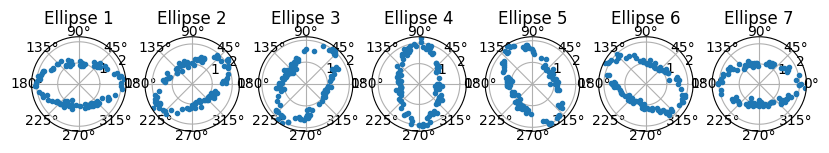

In [4]:
angles = [angle for angle in 0:π/6:π]
f1 = figure("Ellipses",figsize=(10,10))
for (i, angle) in enumerate(angles)
    data = generate_ellipse(2,1,angle,100,0.1)
    ax1 = subplot(1,length(angles),i, polar=true,)
    t = title(string("Ellipse ",i))
    pl1 = plot( data[:,1], data[:,2], linestyle="None", marker="." ) ;
    ax1[:set_theta_zero_location]("E") ;
end